# 0. Drahtlose Kommunikation

## 0.1 Bildquellen und Vorlesungsinhalte
Die in diesem Dokument verwendeten Bilder, sofern sich nicht mit dem hier aufgeführten Code generiert wurden, stammen aus dem PC-Übungsskript "Drahtlose Kommunikation - MATLAB Rechenübung" von Dipl. -ing Lutz Molle und Prof. Dr. -ing. Markus Nölle an der HTW Berlin. Sie wurden teilsweise zur besseren Darstellung von mir verändert.


# 1. Simulation des Übertragungssystems

Die Funktionen werden immer paarweise implementiert, da sie ähnlich wie beim OSI Modell komplementäre Funktionen ausüben.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from tqdm import tqdm
from typing import List, Set, Dict, Tuple, Any, Callable

In [2]:
%load_ext lab_black
IPython.display.set_matplotlib_formats("pdf", "svg")

## 1.1 Quelle und Senke
![Quelle und Senke](Images/01_Quell_Senke.png)

In [3]:
def generate_bits(n_bits: int) -> np.ndarray:
    """
    Generate numpy array with n_bits values.

    n_bits: Number of bits to generate
    :return: Randomly generated bits.
    """

    if not isinstance(n_bits, int):
        raise TypeError("Expected n_bits to be of type int.")

    bit_vector: np.ndarray = np.random.randint(0, 2, size=n_bits)
    return bit_vector

In [4]:
def count_errors(
    true_values: np.ndarray, tested_values: np.ndarray
) -> Tuple[int, float]:
    """
    Get two bit vectors an compere them.
    Returns count of different bits an bit-error-racio.
    The lenth of both vectors should be equal.
    Both input vectors must be of type bool.

    true_values: Original values.
    tested_values: Values to compare to original values.
    """

    if len(true_values) != len(tested_values):
        raise ValueError("Lengths of bit vectores are different.")
    for item in true_values:
        if item != 0 and item != 1:
            raise TypeError(f"Expected true_values to be ether 0 or 1. Got: {item}")
    for item in tested_values:
        if item != 0 and item != 1:
            raise TypeError(f"Expected tested_values to be ether 0 or 1. Got: {item}")

    equal_bits: np.ndarray = true_values == tested_values
    n_error: int = len(true_values) - int(np.count_nonzero(equal_bits))
    bit_error_rate: float = n_error / len(true_values)
    return (n_error, bit_error_rate)

# 1.2 Kanal codierung
![Kanal codierung](Images/02_Kanal_Codierung.png)

# 1.3 Mapper, Demapper, Entscheider
![Mapper, Demapper, Entscheider](Images/03_Mapper.png)

In [5]:
def mapper(bits: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Get array of bits and map them to an array of symbols.
    Bit vector length and constellation vector length must agree.

    bits: Bits to map to symbols.
    constellation: Available symbols to map to.
    :return: Mapped symbols.
    """
    # len_bits: int = len(bits)
    len_constellation: int = len(constellation)

    symbols: List[complex] = []
    slices: List[complex] = []
    bits_per_symbol: int = int(np.log2(len_constellation))
    bit_nr: int = 0
    for bit in bits:
        slices.append(bit)
        if len(slices) == bits_per_symbol:
            symbols.append(constellation[tuple(slices)])
            slices = []
        elif len(slices) > bits_per_symbol:
            raise ValueError("TBD")
    # Fehler Mehr bits als constalltions her gibt.
    if len(slices) > 0:
        raise ValueError(
            f"Bit vector has not the right length. There are {len(slices)} bit(s) to much."
        )

    return np.array(symbols)

In [6]:
def decission(symbols: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Get array of symbols. Return array of symboles where eukledian
    distance to the origianl Symbol.

    symbols: List of noisy input symbols.
    constallation: Table of constallation symbols.
    :return: List of decided symbols.
    """

    # Constellation Dict/Table to constellation vector
    constellation_list: List[complex] = [constellation[key] for key in constellation]
    constellation_vector: np.ndarray = np.array(constellation_list)

    # Normalize symbols to constellation
    constellation_rms: np.ndarray = np.sqrt(np.mean(np.abs(constellation_vector) ** 2))
    symbols_rms: np.ndarray = np.sqrt(np.mean(np.abs(constellation_vector) ** 2))
    normalisation_factor: np.ndarray = symbols_rms / constellation_rms
    symbols = symbols / normalisation_factor  # Symbols normalized to constellation

    # Calculate for every Symbol dicission gets the distance (Eucledian distance)
    # to every possible symbol. Least distance winns.
    decission: List[complex] = []
    for symbol in symbols:
        distance: List[complex] = []
        for const_symbol in constellation_vector:
            distance.append(np.linalg.norm(const_symbol - symbol))
        const_index = distance.index(min(distance))
        decission.append(constellation_vector[const_index])
    return np.array(decission)

In [7]:
def demapper(symbols: np.ndarray, constellation: np.ndarray) -> np.ndarray:
    """
    Get symbol and retunrns corresponding bit sequence.

    symbols: Sybol carring bit information.
    constellation: Constellation Table to decode.
    :return: Byte information.
    """
    reverse_constallation: dict = dict(
        [(constellation[key], key) for key in constellation]
    )
    bit_tuples: List[int] = [reverse_constallation[symbol] for symbol in symbols]
    bits: List[int] = []
    for bit_tuple in bit_tuples:
        for bit in bit_tuple:
            bits.append(bit)

    return np.array(bits)

# 1.4 Kanal (Funk, Kabel, ...)
![Kanal (Funk, Kabel, ...](Images/04_Kanal.png)

### 1.4.1 AWGN

In [8]:
# Ideas from:
# https://stackoverflow.com/a/53688043
# 8 Dec 2018 at 23:31 by tmcdevitt
def awgn(signal: np.ndarray, snr_s: float):
    """
    Add AWGN to signal.

    signal: Signal to add noise.
    snr_b: Signal to noise ratio per symbol in dB.
    :return: Noisy signal.
    """
    # Calculate power of signal
    signal_power: float = float(
        (1.0 / len(signal)) * np.sum(np.abs(signal) ** 2)  # Power = RMS ** 2
    )

    # SNR linear
    snr_linear: float = 10 ** (snr_s / 10)

    # Noise Power linear
    nois_power_linear: float = signal_power / snr_linear

    # Generate noise samples
    mean_noise: float = 0.0
    noise = np.random.normal(mean_noise, np.sqrt(nois_power_linear), len(signal))

    # Noise up the original signal
    noisy_signal: np.ndarray = signal + noise
    return noisy_signal

### 1.4.2 Radio fading channel

In [9]:
def radio_fading_channel(n_samples: np.ndarray) -> np.ndarray:
    """
    Genergate n_samples of gaussian distributetd channel koefficents.
    Kanalkoeffizient je symbol, da sich der Kanal pro Symbol ändert.

    n_samples:
    :return:
    """
    mean_noise: float = 0.0
    std_dev: float = 0.5
    samples = np.random.normal(mean_noise, std_dev, size=(n_samples, 2))
    samples = np.squeeze(samples.view(np.complex), axis=1)
    # RMS
    samples_rms = np.sqrt(np.mean(np.square(np.abs(samples))))
    samples /= samples_rms  # Normierung, da der Kanal weder versärkt noch schwächt
    return samples

# 2. Demonstration der einzelnen Funktionen
## 2.1 Quelle und Senke
### 2.1.1 Quelle
Die Quelle generiert eine beliebige anzahl (n_bits) an [zufälligen](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.htmlhttps://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) bits.

In [10]:
random_bits: np.ndarray = generate_bits(10)

print(f"Zufällige bits: {random_bits}")

Zufällige bits: [0 1 1 0 1 0 1 1 1 0]


### 2.1.2 Senke
In der Senke werden die eingegangen bits mit den eigentlich gesendeten Bits verglichen. Es wird die absolute Anzahl an flaschen Bits sowie die BER (Bit error rate) berechnet.  
BER = $\frac{falsch\_empfangen}{absolut\_empfangen}$
Schelchtester Fall ist $BER = 0.5$. Das würde Raten entsprechen. Ist der BER = 1 geht wie bei 0 kein Informationsgehalt verloren, da die Werte durch invertieren wiederhergestellt werden können.

In [11]:
true_values: np.ndarray = np.array([1, 1, 1, 0])
test_values: np.ndarray = np.array([1, 0, 1, 0])
bit_errors: int
ber: float
bit_errors, ber = count_errors(true_values, test_values)

print(f"Gesendete Bits:  {true_values}")
print(f"Empfangene Bits: {test_values}")
print(f"Falsche Bits:    {bit_errors}")
print(f"BER:             {ber}")

Gesendete Bits:  [1 1 1 0]
Empfangene Bits: [1 0 1 0]
Falsche Bits:    1
BER:             0.25


## 2.2 Mapper, Demapper, Entscheider
Mapper symbols from [LTE Specification](https://www.etsi.org/deliver/etsi_ts/136200_136299/136211/13.07.01_60/ts_136211v130701p.pdf) S. 133f

In [12]:
CONST_BPSK: Dict[Tuple, complex]
CONST_BPSK = {
    # (0,): +1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
    # (1,): -1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
    (0,): +1 + 1j,
    (1,): -1 - 1j,
}
CONST_QPSK: Dict[Tuple, complex]
CONST_QPSK = {
    # (0, 0): +1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
    # (0, 1): +1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
    # (1, 0): -1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
    # (1, 1): -1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
    (0, 0): +1 + 1j,
    (0, 1): +1 - 1j,
    (1, 0): -1 + 1j,
    (1, 1): -1 - 1j,
}
CONST_16QAM: Dict[Tuple, complex]
CONST_16QAM = {
    (0, 0, 0, 0): +1 / np.sqrt(10) + 1 / np.sqrt(10),
    (0, 0, 0, 1): +1 / np.sqrt(10) + 3 / np.sqrt(10),
    (0, 0, 1, 0): +3 / np.sqrt(10) + 1 / np.sqrt(10),
    (0, 0, 1, 1): +3 / np.sqrt(10) + 3 / np.sqrt(10),
    (0, 1, 0, 0): +1 / np.sqrt(10) - 1 / np.sqrt(10),
    (0, 1, 0, 1): +1 / np.sqrt(10) - 3 / np.sqrt(10),
    (0, 1, 1, 0): +3 / np.sqrt(10) - 1 / np.sqrt(10),
    (0, 1, 1, 1): +3 / np.sqrt(10) - 3 / np.sqrt(10),
    (1, 0, 0, 0): -1 / np.sqrt(10) + 1 / np.sqrt(10),
    (1, 0, 0, 1): -1 / np.sqrt(10) + 3 / np.sqrt(10),
    (1, 0, 1, 0): -3 / np.sqrt(10) + 1 / np.sqrt(10),
    (1, 0, 1, 1): -3 / np.sqrt(10) + 3 / np.sqrt(10),
    (1, 1, 0, 0): -1 / np.sqrt(10) - 1 / np.sqrt(10),
    (1, 1, 0, 1): -1 / np.sqrt(10) - 3 / np.sqrt(10),
    (1, 1, 1, 0): -3 / np.sqrt(10) - 1 / np.sqrt(10),
    (1, 1, 1, 1): -3 / np.sqrt(10) - 3 / np.sqrt(10),
}
CONSTELLATION: Dict[str, Dict]
CONSTELLATION = {
    "bpsk": CONST_BPSK,
    "qpsk": CONST_QPSK,
    "16qam": CONST_16QAM,
}

### 2.2.1 Mapper
Der Mapper weist einer Bit-Gruppe ein Konstellationssymbol zu. Je nach Anzahl der Konstallationssymbole kann ein Symbol die Information von mehereren Bits tragen.
$symbol_{anz} \hat{=} 2^{bit_{anz}}$
Umgekehrt ${bit_{anz}} \hat{=} \log_{2}{symbol_{anz}}$

In [13]:
bits: np.ndarray = np.array([1, 0])
constellation = CONSTELLATION["bpsk"]
mapped_symbols: np.ndarray = mapper(bits, constellation)
print(f"Konstellations Tabelle:")
for key in constellation:
    print(f"{key} = {constellation[key]}")
print(f"Bits:   {bits}")
print(f"Mapped: {mapped_symbols}")

Konstellations Tabelle:
(0,) = (1+1j)
(1,) = (-1-1j)
Bits:   [1 0]
Mapped: [-1.-1.j  1.+1.j]


In [14]:
def plot_symbols(symbols: np.ndarray) -> None:
    ORIGIN = (0, 0)

    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
    fig.suptitle(f"Symbol{'e' if len(symbols) > 1 else ''} auf der Komplexen ebene.")

    ax = fig.add_subplot(axs)
    ax.grid(True)
    # ax.set_xlim(-1.5, 1.5)
    # ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginär")

    for symbol in symbols:
        ax.scatter(symbol.real, symbol)
    # plt.arro1(0, 0, 1, 1, color=["r"], scale=21)
    plt.show()

Darstellung des Symbols auf der komplexen Ebene

/home/flo/git-repos/M16-Drahtlose-Kommunikation/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


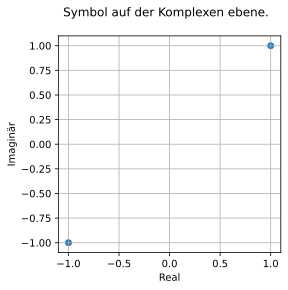

In [15]:
bits: np.ndarray = np.array([0, 1, 1, 0])
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
mapped_symbols: np.ndarray = mapper(bits, constellation)
plot_symbols([mapped_symbols])

### 2.2.1 Entscheider
Entscheidet sich für das Symbol, welches zu dem empfangen Symbol die geringste eukliedische Distanz hat.

/home/flo/git-repos/M16-Drahtlose-Kommunikation/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Noisy symbols:   [ 1.1+0.9j -1.2-1.3j -1. +0.9j]
Decided symbols: [ 1.+1.j -1.-1.j -1.+1.j]


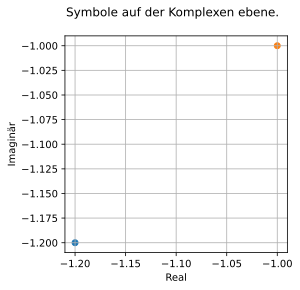

In [16]:
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
noisy_symbols: np.ndarray = np.array([1.1 + 0.9j, -1.2 - 1.3j, -1 + 0.9j])
decision_symbols: np.ndarray = decission(noisy_symbols, constellation)
print(f"Noisy symbols:   {noisy_symbols}")
print(f"Decided symbols: {decision_symbols}")
plot_symbols([noisy_symbols[1], decision_symbols[1]])

### 2.2.2 Demapper

In [17]:
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
symbols: np.ndarray = np.array([-1 + 1j, -1 - 1j, -1 + 1j])
bits: np.ndarray = demapper(symbols, constellation)
print(f"Konstellations Tabelle:")
for key in constellation:
    print(f"{key} = {constellation[key]:.2f}")
print(f"Symbols:         {symbols}")
print(f"Demapped Bits:   {bits}")

Konstellations Tabelle:
(0, 0) = 1.00+1.00j
(0, 1) = 1.00-1.00j
(1, 0) = -1.00+1.00j
(1, 1) = -1.00-1.00j
Symbols:         [-1.+1.j -1.-1.j -1.+1.j]
Demapped Bits:   [1 0 1 1 1 0]


## 2.3 AWGN
Add wihte gaussian nois to a signal.

<function matplotlib.pyplot.show(close=None, block=None)>

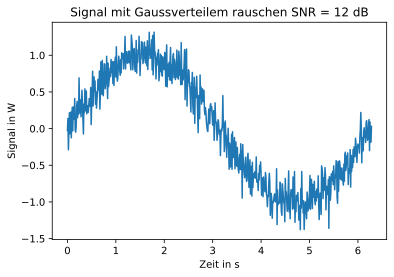

In [18]:
time: np.ndarray = np.arange(0, 2 * np.pi, 0.01)
signal: np.ndarray = np.sin(time)
noise_db = 12
noisy_signal: np.ndarray = awgn(signal, noise_db)
plt.plot(time, noisy_signal)
plt.xlabel("Zeit in s")
plt.ylabel("Signal in W")
plt.title(f"Signal mit Gaussverteilem rauschen SNR = {noise_db} dB")
plt.show

## 2.4 Radio Fading Channel / Schwundkanal

<function matplotlib.pyplot.show(close=None, block=None)>

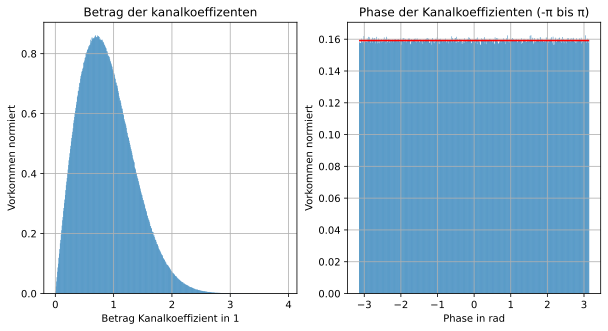

In [19]:
signal: np.ndarray = radio_fading_channel(int(10e6))

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=[10, 5])
ax0 = fig.add_subplot(axs[0])
ax1 = fig.add_subplot(axs[1])

ax0.hist(np.abs(signal), bins=500, density=1)
ax0.set_xlabel("Betrag Kanalkoeffizient in 1")
ax0.set_ylabel("Vorkommen normiert")
ax0.set_title(f"Betrag der kanalkoeffizenten")
ax0.grid(True, which="major")
ax0.grid(True, which="minor")

ax1.hist(np.angle(signal, deg=False), bins=500, density=1)
ax1.hlines(
    1 / (2 * np.pi),
    -np.pi,
    np.pi,
    colors="r",
    linestyles="solid",
    label="Error threshold",
)
ax1.set_xlabel("Phase in rad")
ax1.set_ylabel("Vorkommen normiert")
ax1.set_title(f"Phase der Kanalkoeffizienten (-π bis π)")
ax1.grid(True, which="major")
ax1.grid(True, which="minor")

plt.show

# 3. Komplette Simulation

## 3.1 AWGN Kanal

### 3.1.1 Simulation

In [20]:
def simulation_awgn(n_bits, constellation, snr_b) -> Tuple[int, float]:
    """

    This is the complet simmulation of a AWGN channel.
    """
    # Generate bits
    source_bits: np.ndarray = generate_bits(n_bits)

    # Mapp symbols
    mapped_symbols: np.ndarray = mapper(source_bits, constellation)

    # Add Noise
    snr_s = snr_b * np.log2(len(constellation))
    noisy_signal: np.ndarray = awgn(mapped_symbols, snr_s)

    # Decide symbols
    decided_symbols = decission(noisy_signal, constellation)

    # Demap bits
    demapped_bits: np.ndarray = demapper(decided_symbols, constellation)

    # Count errors
    bit_errors: int
    ber: float
    bit_errors, ber = count_errors(source_bits, demapped_bits)
    return bit_errors, ber

In [21]:
constellation = CONSTELLATION["bpsk"]
bit_errors, ber = simulation_awgn(n_bits=100, constellation=constellation, snr_b=0)
print(f"Errors: {bit_errors}")
print(f"BER:    {ber}")

Errors: 7
BER:    0.07


### 3.1.2 Visualisierung

In [22]:
n_min_error = 100
n_bits = 100000
max_iterations = 20
# Signal to noise rations
snr_bs: np.ndarray = np.arange(0, 12, 1)

# Error rates for each SNR
bers = []
for snr_b in snr_bs:
    loop_errors = 0
    for i in tqdm(range(max_iterations), desc=f"snr_b: {snr_b}"):
        bit_errors, ber = simulation_awgn(n_bits, CONSTELLATION["bpsk"], snr_b)
        loop_errors += bit_errors
        if loop_errors >= 100:
            break
    bers.append(ber)

bers_a = np.array(bers)

snr_b: 11: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


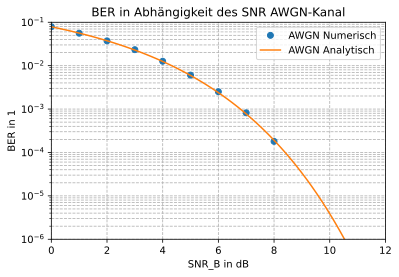

In [23]:
import math
from scipy import special

snr_awgn_anal_db = np.arange(0, 12, 0.1)
snr_awgn_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_awgn_anal = 0.5 * special.erfc(np.sqrt(snr_awgn_anal_lin))
plt.plot(snr_bs, bers_a, "o", label="AWGN Numerisch")
plt.plot(snr_awgn_anal_db, ber_awgn_anal, label="AWGN Analytisch")
plt.legend()
plt.yscale("log")
plt.xlim(0, 12)
plt.ylim(1e-6, 1e-1)
plt.xlabel("SNR_B in dB")
plt.ylabel("BER in 1")
plt.title(f"BER in Abhängigkeit des SNR AWGN-Kanal")
plt.grid(True, which="both", linestyle="--")
plt.show()

## 3.2 Simulation des Rayleigh Kanal

### 3.2.1 Simulation Funktion

In [24]:
def simulation_rayleigh(n_bits, constellation, snr_b) -> Tuple[int, float]:
    """

    This is the complet simmulation of a Rayleigh channel.
    """
    # Generate bits
    source_bits: np.ndarray = generate_bits(n_bits)

    # Mapp symbols
    mapped_symbols: np.ndarray = mapper(source_bits, constellation)

    # Add Channel coefficents
    channel_coeff = radio_fading_channel(len(mapped_symbols))
    fading_signal = mapped_symbols * channel_coeff
    # fading_signal = mapped_symbols

    # Add Noise
    # plot_symbols(channel_coeff)
    snr_s = snr_b * np.log2(len(constellation))  # bit noise to symbol noise
    noisy_signal: np.ndarray = awgn(fading_signal, snr_s)

    # Compensate coefficents
    # compensated_signal = noisy_signal / channel_coeff
    compensated_signal = noisy_signal

    # Decide symbols
    decided_symbols = decission(compensated_signal, constellation)

    # Demap bits
    demapped_bits: np.ndarray = demapper(decided_symbols, constellation)

    # Count errors
    bit_errors: int
    ber: float
    bit_errors, ber = count_errors(source_bits, demapped_bits)
    return bit_errors, ber

In [25]:
constellation = CONSTELLATION["qpsk"]
bit_errors, ber = simulation_rayleigh(
    n_bits=1000000, constellation=constellation, snr_b=20
)
print(f"Errors: {bit_errors}")
print(f"BER:    {ber}")

Errors: 500539
BER:    0.500539


### 3.2.2 Visualisierung / Diagramme

In [26]:
n_min_error = 100
n_bits = 100000
max_iterations = 1
# Signal to noise ratios
snr_bs: np.ndarray = np.arange(0, 30, 1)

# Error rates for each SNR
bers = []
for snr_b in snr_bs:
    loop_errors = 0
    for i in tqdm(range(max_iterations), desc=f"snr_b: {snr_b}"):
        bit_errors, ber = simulation_rayleigh(n_bits, CONSTELLATION["qpsk"], snr_b)
        loop_errors += bit_errors
        if loop_errors >= 100:
            break
    bers.append(ber)

bers_a = np.array(bers)

snr_b: 29:   0%|          | 0/1 [00:01<?, ?it/s]


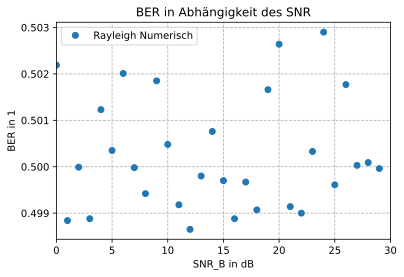

In [27]:
snr_awgn_anal_db = np.arange(0, 12, 0.1)
snr_awgn_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_awgn_anal = 0.5 * special.erfc(np.sqrt(snr_awgn_anal_lin))
# plt.plot(snr_awgn_anal_db, ber_awgn_anal, label="AWGN Analytisch")
snr_rayleigh_anal_db = np.arange(0, 30, 0.1)
snr_rayleigh_anal_lin = 10 ** (snr_rayleigh_anal_db / 10)
ber_rayleigh_anal = 0.5 * (
    1 - np.sqrt(snr_rayleigh_anal_lin / (1 + snr_rayleigh_anal_lin))
)
plt.plot(snr_bs, bers_a, "o", label="Rayleigh Numerisch")
# plt.plot(snr_rayleigh_anal_db, ber_rayleigh_anal, label="rayleigh Analytisch")
plt.yscale("linear")
plt.xlim(0, 30)
# plt.ylim(1e-6, 1e-1)
plt.legend()
plt.xlabel("SNR_B in dB")
plt.ylabel("BER in 1")
plt.title(f"BER in Abhängigkeit des SNR")
plt.grid(True, which="both", linestyle="--")
plt.show()

## 3.3 Simulation des Rice Kanal

### 3.3.1 Simulation funktion

In [28]:
def simulation_rice(n_bits, constellation, snr_b) -> Tuple[int, float]:
    """

    This is the complet simmulation of a Rice channel.
    """
    pass
    return bit_errors, ber

### 3.3.2 Visualisierung / Diagramme

In [29]:
pass

In [30]:
const = np.array(
    [
        +1 + 1j,
        +1 - 1j,
        -1 + 1j,
        -1 - 1j,
    ]
)

In [31]:
n_samples = 100
mean_noise: float = 0.0
std_dev: float = 0.35
samples = np.random.normal(mean_noise, std_dev, size=(n_samples, 2))
samples = np.squeeze(samples.view(np.complex), axis=1)
# RMS
samples_rms = np.sqrt(np.mean(np.abs(samples) ** 2))
samples /= samples_rms  # Normierung, da der Kanal weder versärkt noch schwächt

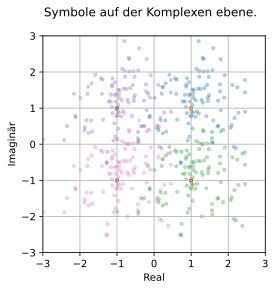

In [32]:
a = samples + const[0] * 1
b = samples + const[1] * 1
c = samples + const[2] * 1
d = samples + const[3] * 1


fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
fig.suptitle(f"Symbole auf der Komplexen ebene.")

ax = fig.add_subplot(axs)
ax.grid(True)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel("Real")
ax.set_ylabel("Imaginär")

ax.scatter(a.real, a.imag, alpha=0.3, s=10)
ax.scatter(const[0].real, const[0].imag, alpha=1, s=10)
ax.scatter(b.real, b.imag, alpha=0.3, s=10)
ax.scatter(const[1].real, const[1].imag, alpha=1, s=10)
ax.scatter(c.real, c.imag, alpha=0.3, s=10)
ax.scatter(const[2].real, const[2].imag, alpha=1, s=10)
ax.scatter(d.real, d.imag, alpha=0.3, s=10)
ax.scatter(const[3].real, const[3].imag, alpha=1, s=10)
plt.show()